In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.2          ✔ dplyr   1.0.0     
✔ tidyr   1.1.0          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "facebook_combined.txt"

# Setup


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




Number of edges in the graph: 88234
Number of nodes (vertices) in the graph: 4039
Is the graph connected? TRUE


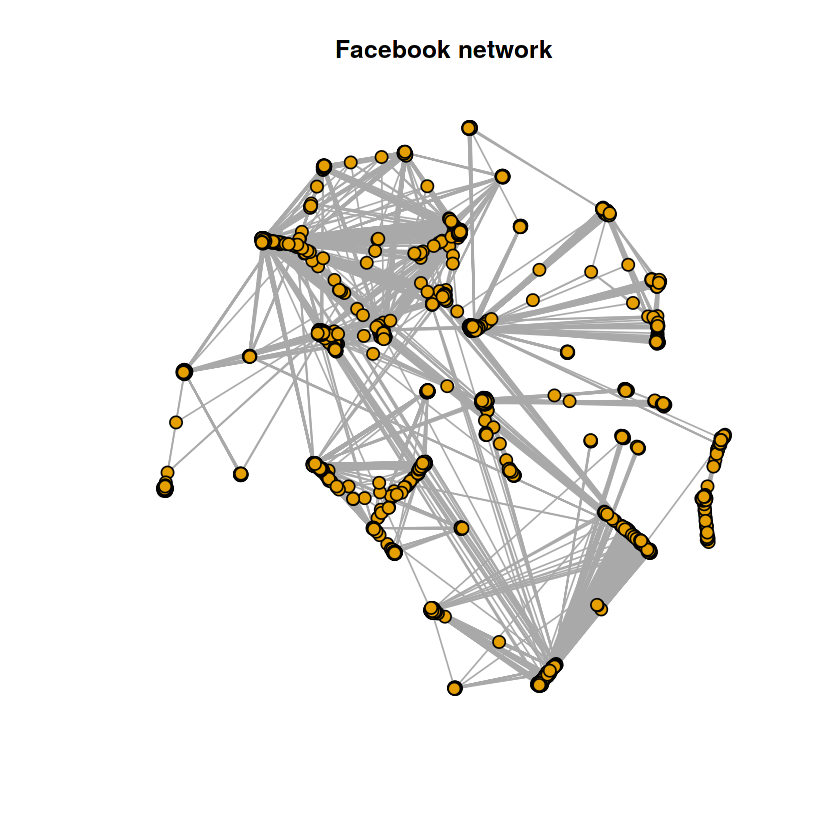

In [2]:
library('igraph')


facebook_txt <- read_graph("../input/facebook_combined.txt", format='ncol', directed = FALSE)
facebook_edge <- as_edgelist(facebook_txt)
g <- graph_from_edgelist(facebook_edge, directed = FALSE)
plot(g, edge.arrow.size=.2, vertex.size=4, vertex.label=NA, main="Facebook network")

#question 1.1
cat(paste('Number of edges in the graph: ', gsize(g), '\n', sep=''))
cat(paste('Number of nodes (vertices) in the graph: ', gorder(g), '\n', sep=''))

#question 1.2
cat(paste('Is the graph connected? ', is.connected(g), '\n', sep=''))


# Question 12 

In [3]:
dispersion_embed = function(G, u, v)
{
    intersect_nei = intersection(neighbors(G, u), neighbors(G, v))
    embeddedness = length(intersect_nei)
    
    if(embeddedness == 0)
    {
        return(c(0, embeddedness))
    }
    
    common_nei = c()
    for(i in 1:length(intersect_nei))
    {
        common_nei = c(common_nei, intersect_nei[i]$name)
    }
    vert_removed = delete_vertices(G, c(u,v))
    node_dist = distances(vert_removed, v=common_nei, to=common_nei)
    
    sum = 0
    for(i in 1:length(node_dist))
    {
        if(node_dist[i] > 2)
        {
            sum = sum + 1
        }
    }

    dispersion = sum/2
    
    return(c(dispersion, embeddedness))
}

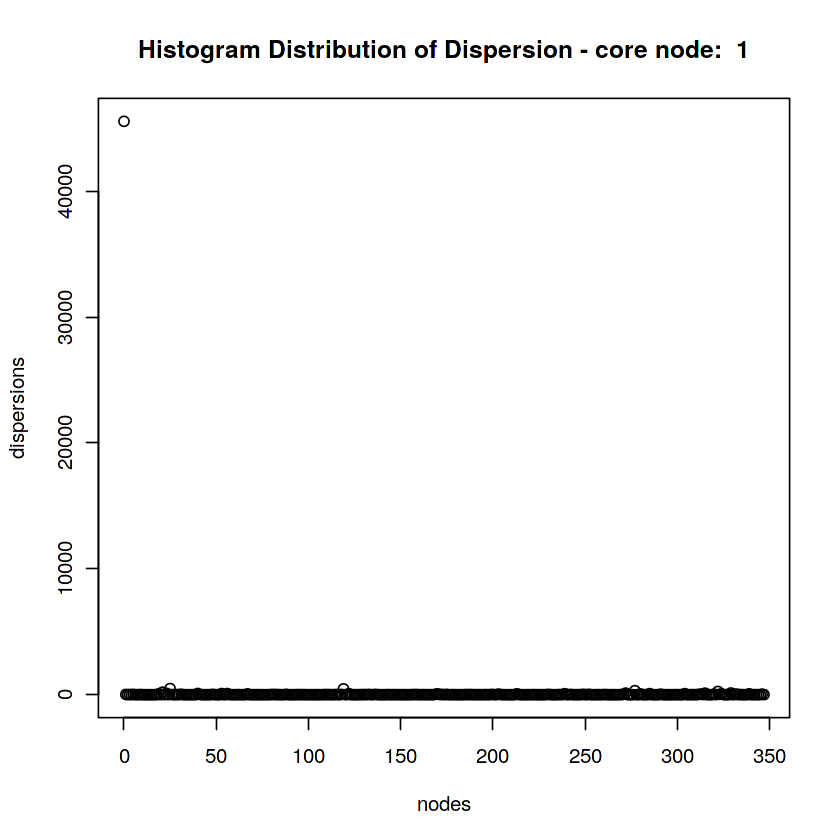

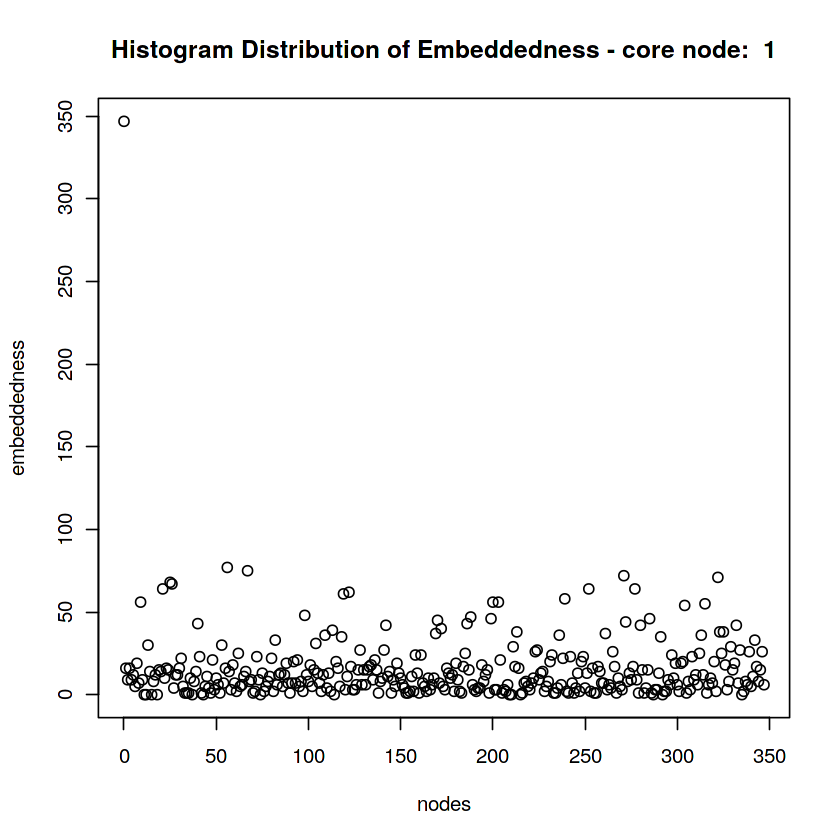

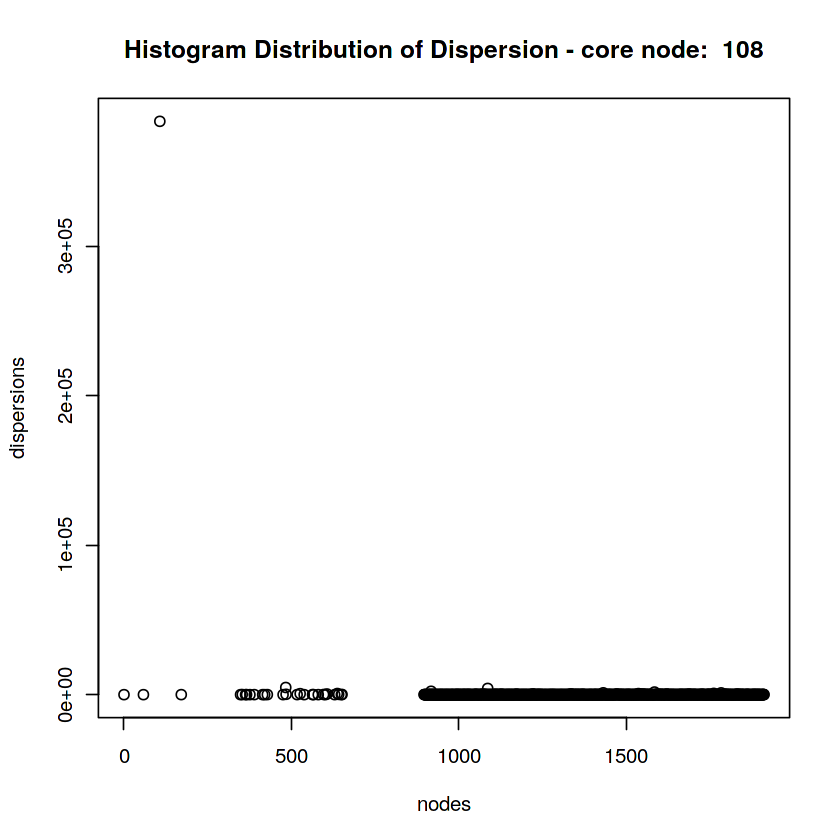

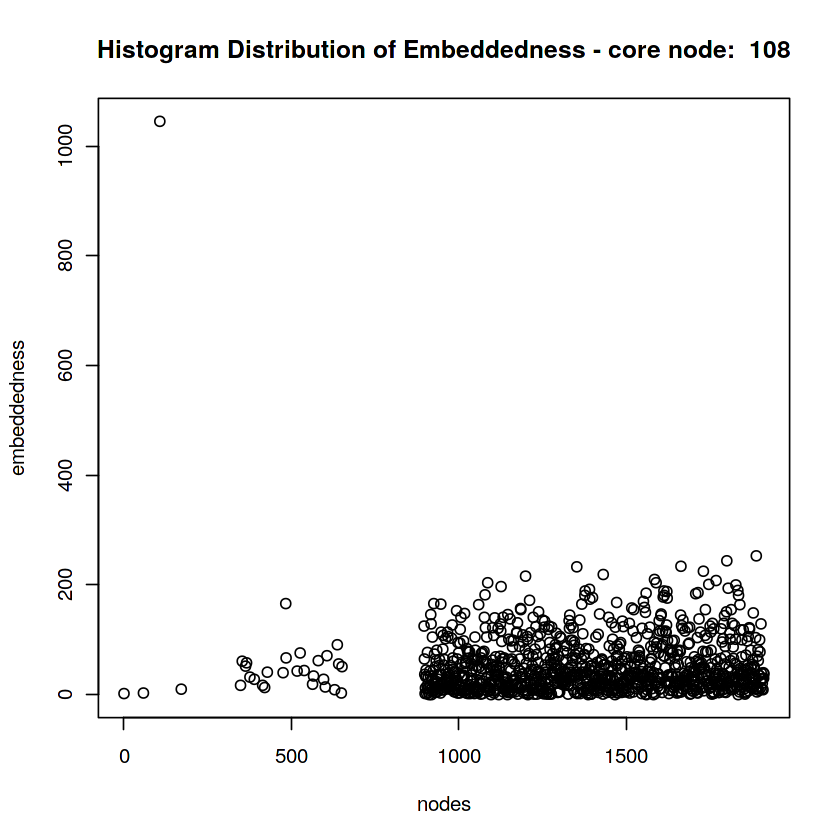

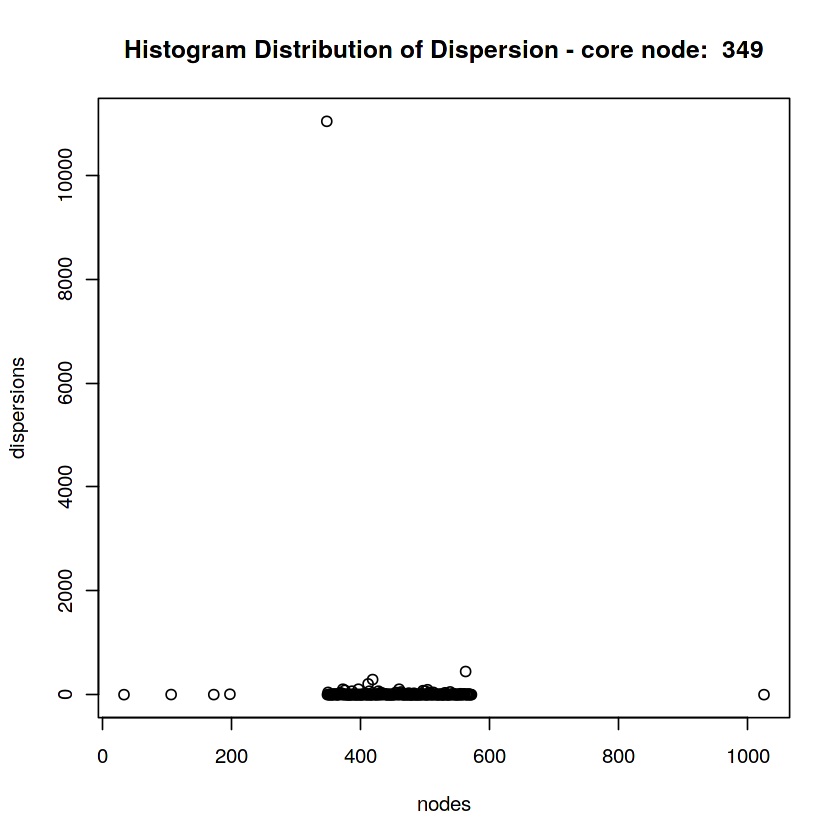

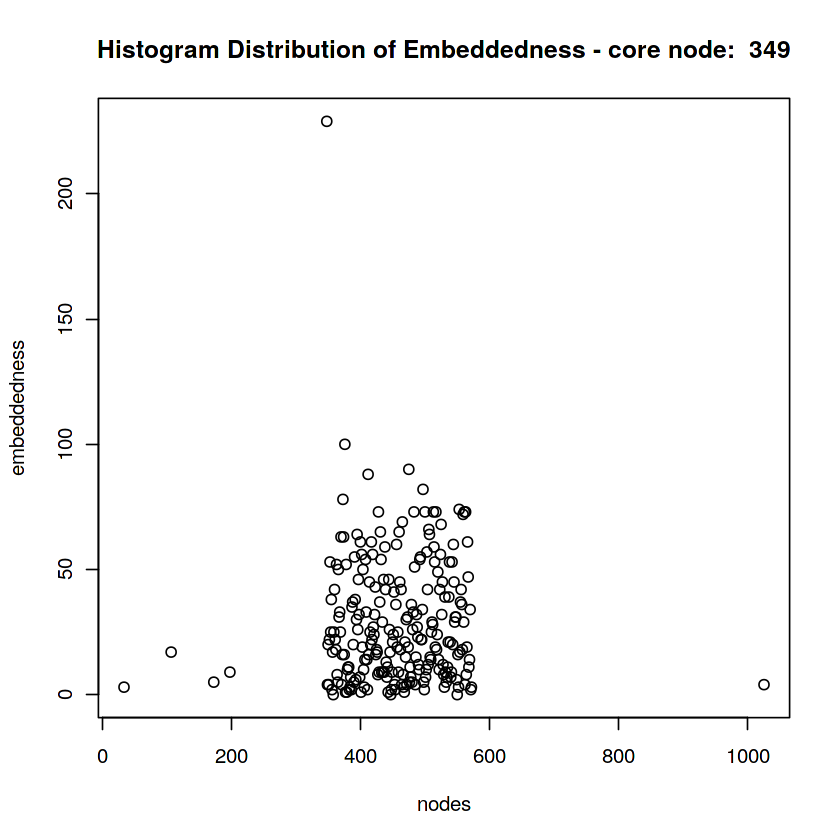

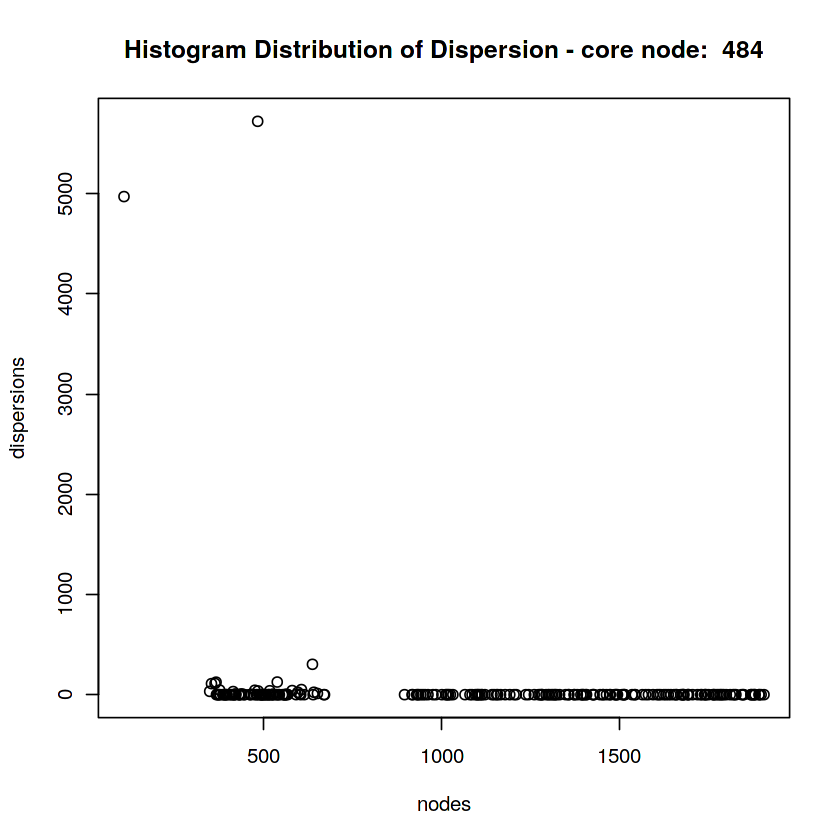

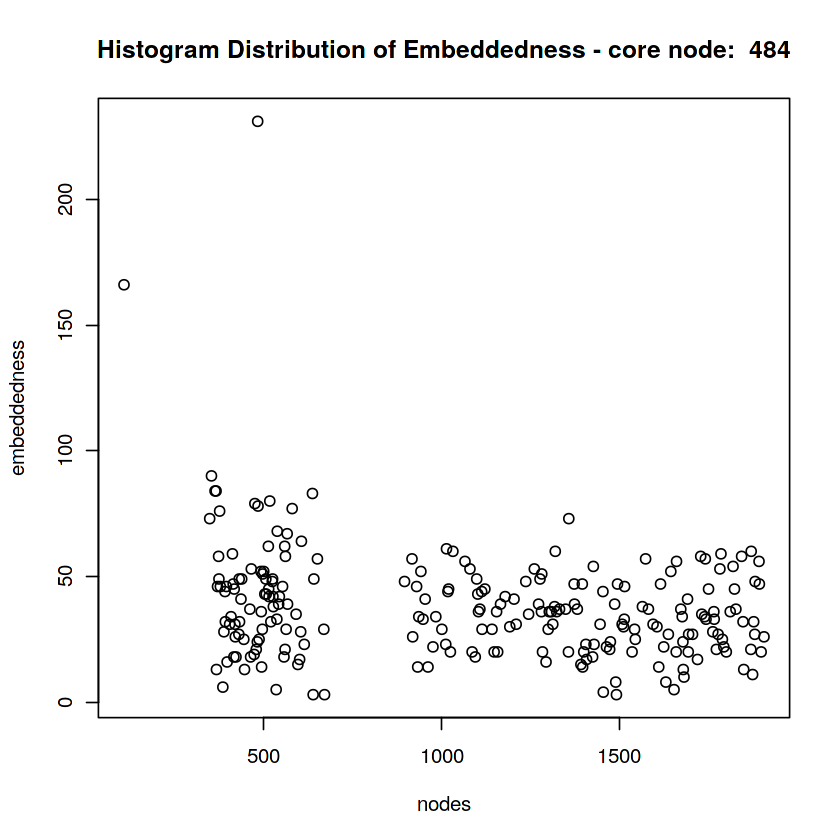

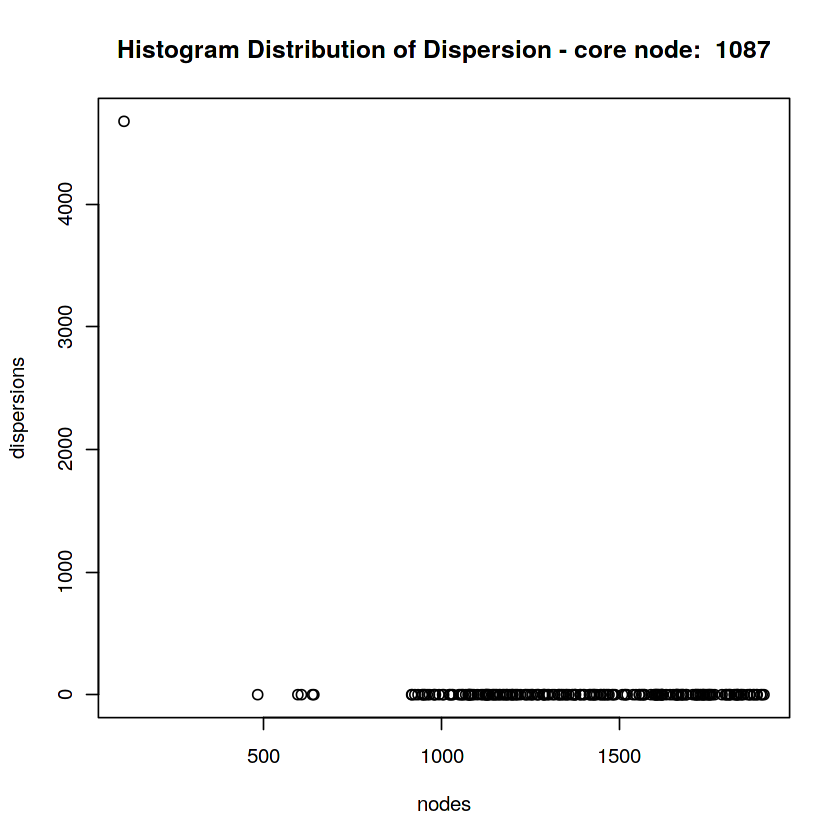

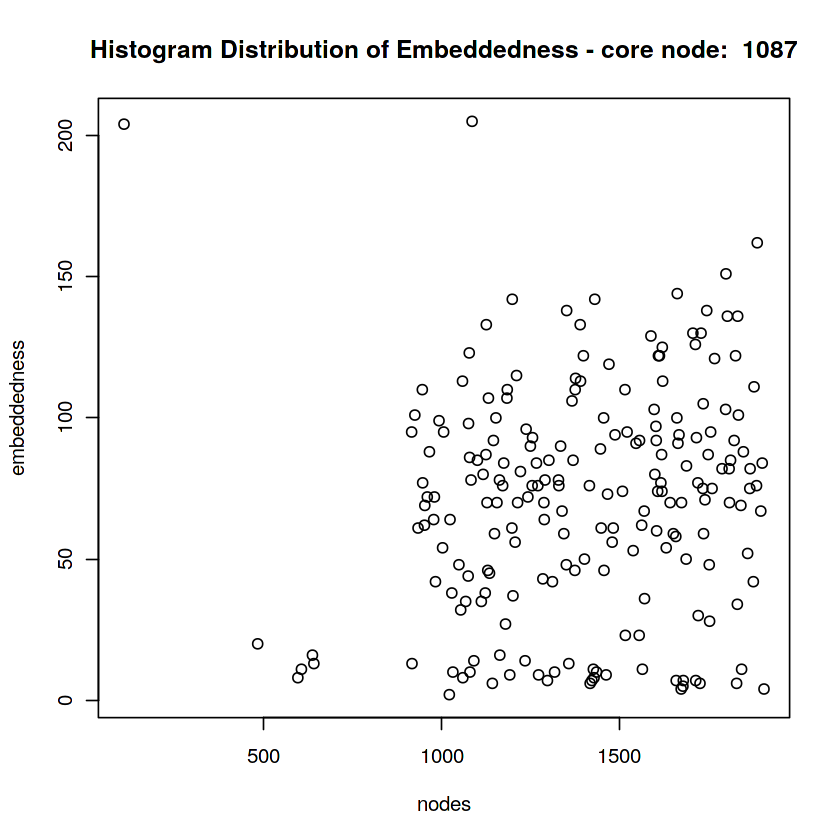

In [4]:


node_ids = c(0,107,348,483,1086)
graph_node_id = c(1,108,349,484,1087)

ego_net = make_ego_graph(g, 1, nodes=c('0','107','348','483','1086'))

for(i in 1:length(node_ids))
{
    personal_net = ego_net[[i]]
    subgraph_nodes = c(V(personal_net)$name)
    dispersions = c()
    embeddedness = c()
    nodes = c()
    
    for(n in subgraph_nodes)
    {
        result = dispersion_embed(personal_net, toString(node_ids[i]), toString(n))
        
        dispersions = c(dispersions, result[1])
        embeddedness = c(embeddedness, result[2])
        nodes = c(nodes, n)
    }
    plot(nodes, dispersions, main=paste('Histogram Distribution of Dispersion - core node: ', graph_node_id[i]))
    plot(nodes, embeddedness, main=paste('Histogram Distribution of Embeddedness - core node: ', graph_node_id[i]))

}


# Question 13

Maximum disperson node, personal net node 1: 25
Maximum disperson node, personal net node 108: 483


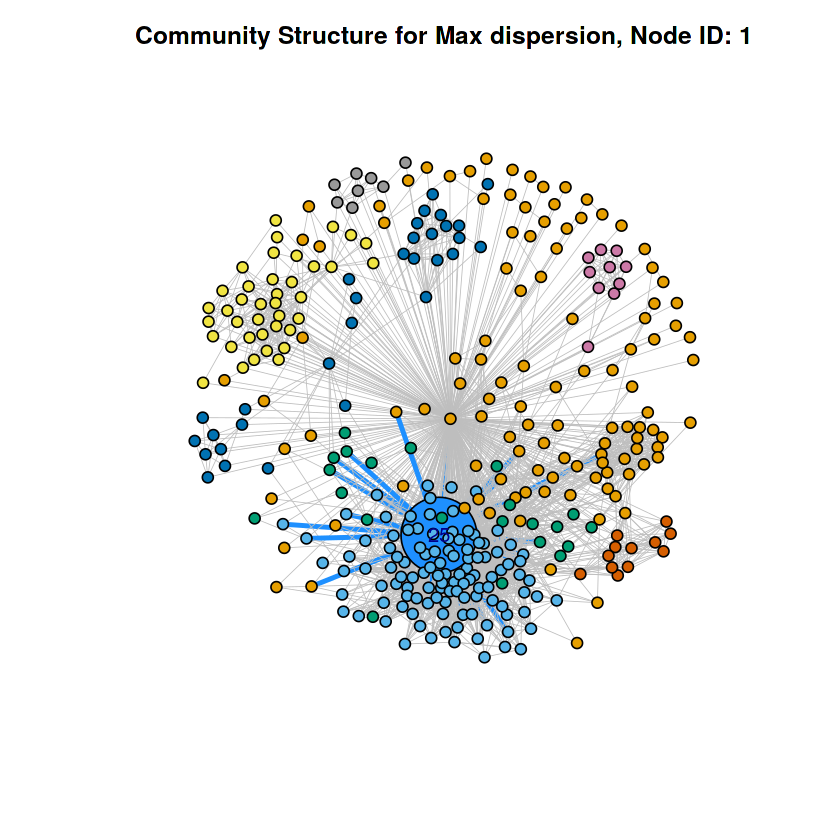

Maximum disperson node, personal net node 349: 563


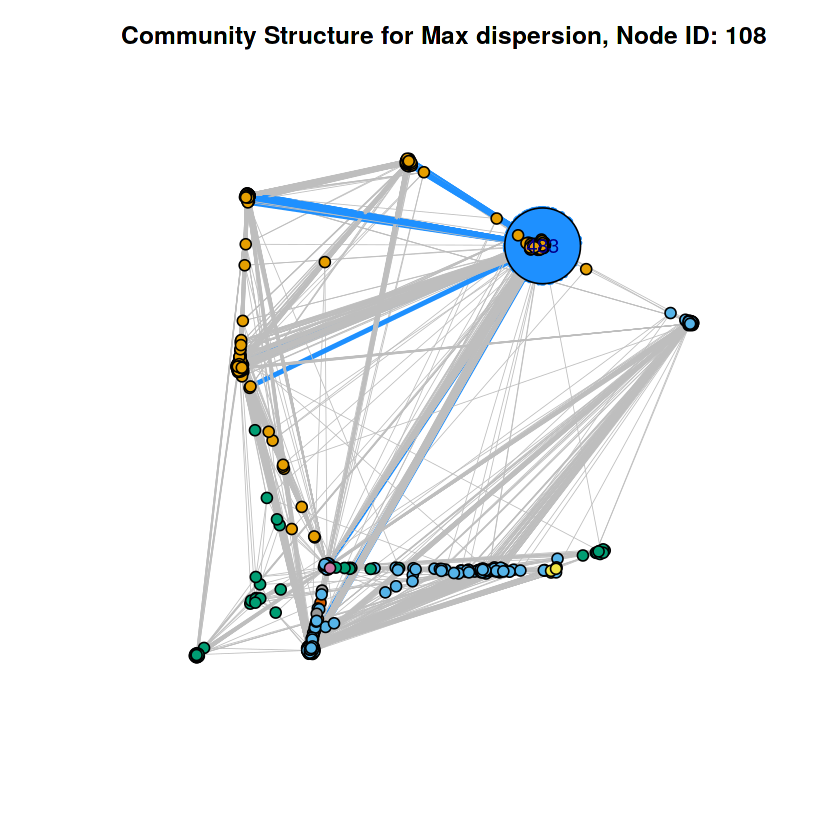

Maximum disperson node, personal net node 484: 107


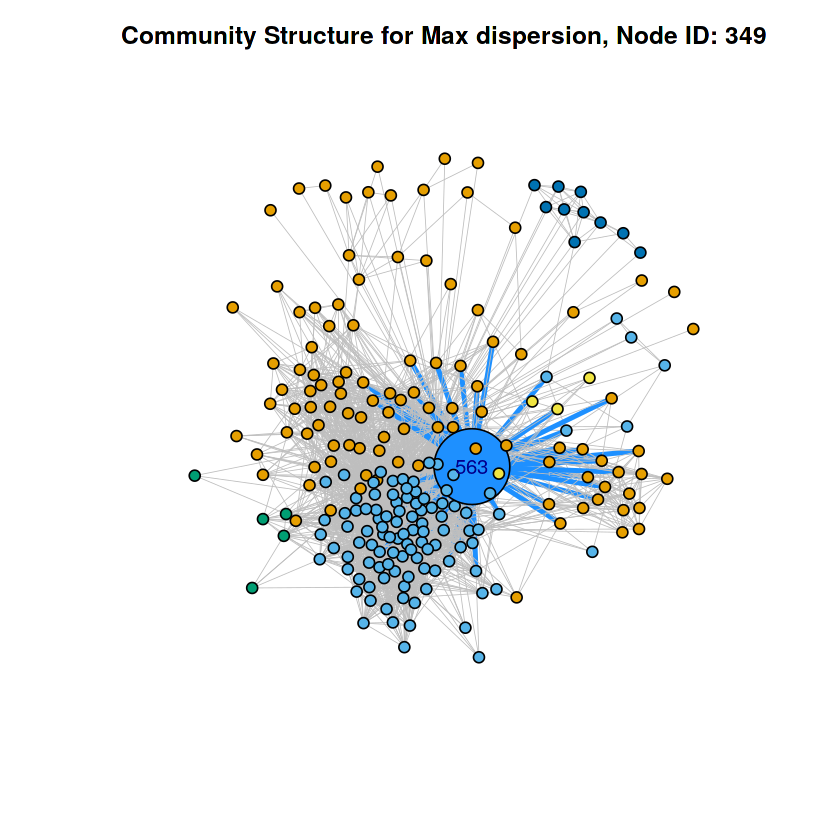

Maximum disperson node, personal net node 1087: 107


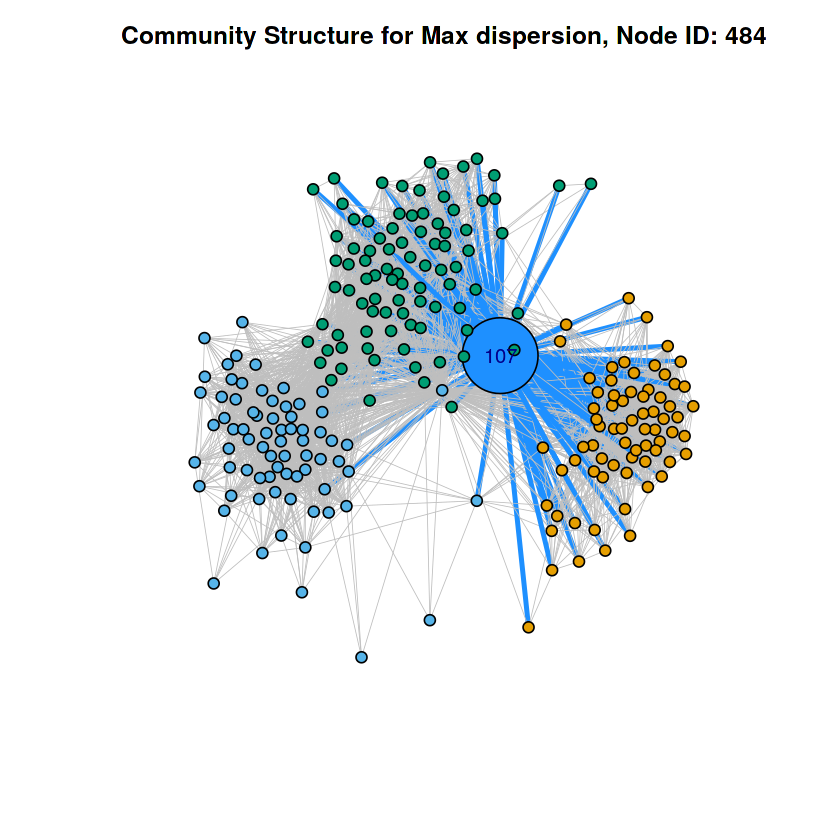

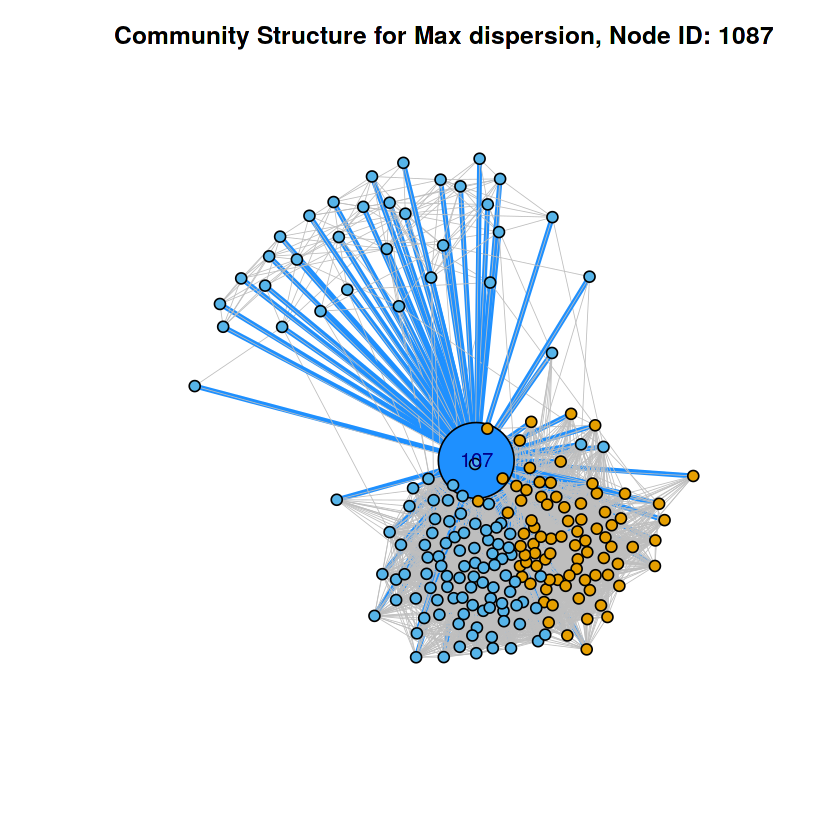

In [5]:

node_ids = c(0,107,348,483,1086)
graph_node_id = c(1,108,349,484,1087)
ego_net = make_ego_graph(g, 1, nodes=c('0','107','348','483','1086'))

for(i in 1:length(node_ids))
{
    personal_net = ego_net[[i]]
    subgraph_nodes = c(V(personal_net)$name)
    max_node =  NA
    max_dispersion = 0
    
    for(n in subgraph_nodes)
    {
        calc_disp_embed = dispersion_embed(personal_net, toString(node_ids[i]), toString(n))
        if(calc_disp_embed[1] > max_dispersion && n != toString(node_ids[i]))
        {
            max_dispersion = calc_disp_embed[1]
            max_node = n
        }
    }
    personal_com = fastgreedy.community(personal_net)
    
    node_color = rep(personal_com$membership, length(V(personal_net)))
    node_size = rep(4, length(V(personal_net)))
    node_label = rep(NA, length(V(personal_net)))
    
    edge_color = rep("gray", length(E(personal_net)))
    edge_weight = rep(0.5, length(E(personal_net)))

    #max coloring/labeling
    node_color[which(V(personal_net)$name == max_node)] = "dodgerblue";
    node_size[which(V(personal_net)$name == max_node)] = 30;
    node_label[which(V(personal_net)$name == max_node)] = max_node;
    
    edge_color[which(get.edgelist(personal_net, name = TRUE)[,1] == max_node | 
                     get.edgelist(personal_net, name = TRUE)[,2] == max_node)] = "dodgerblue";
    edge_weight[which(get.edgelist(personal_net, name = TRUE)[,1] == max_node |  
                      get.edgelist(personal_net, name = TRUE)[,2] == max_node)] = 3;
    ;
    
    cat(paste('Maximum disperson node, personal net node ', graph_node_id[i],  ': ', max_node, '\n', sep=''))
    plot(personal_net, vertex.size = node_size, edge.width = edge_weight, edge.color = edge_color,
    vertex.color = node_color, vertex.label=node_label,
    main = paste('Community Structure for Max dispersion, Node ID: ', graph_node_id[i], '\n', sep=''))
}

# Question 14

Maximum embeddedness node, personal net node 1: 56
Maximum disperson/embeddedness ratio node, personal net 1: 119
Maximum embeddedness node, personal net node 108: 1888
Maximum disperson/embeddedness ratio node, personal net 108: 483


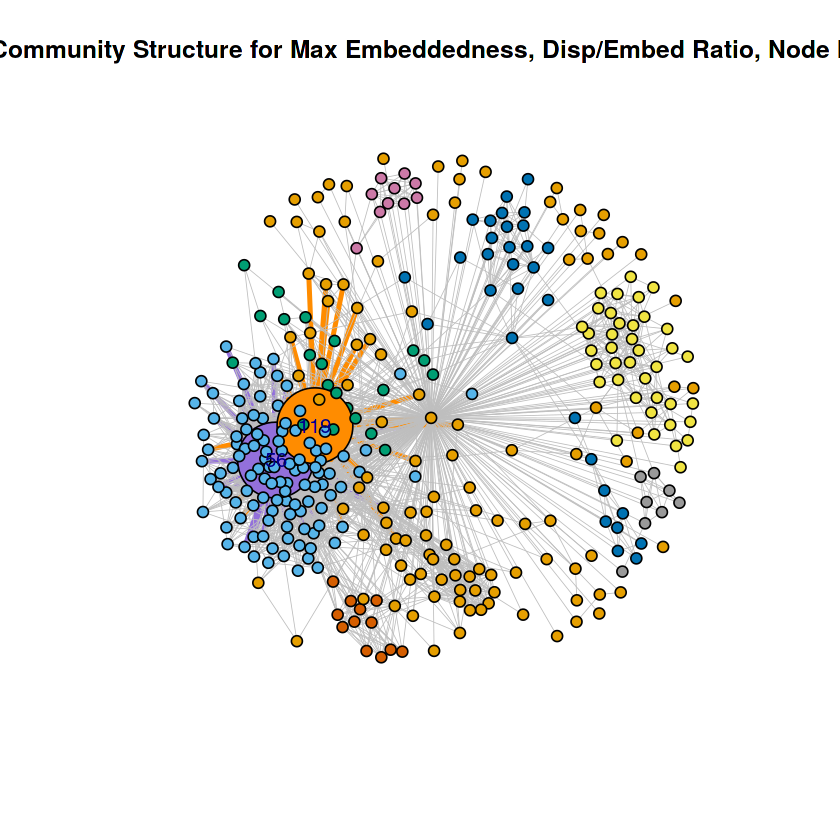

Maximum embeddedness node, personal net node 349: 376
Maximum disperson/embeddedness ratio node, personal net 349: 563


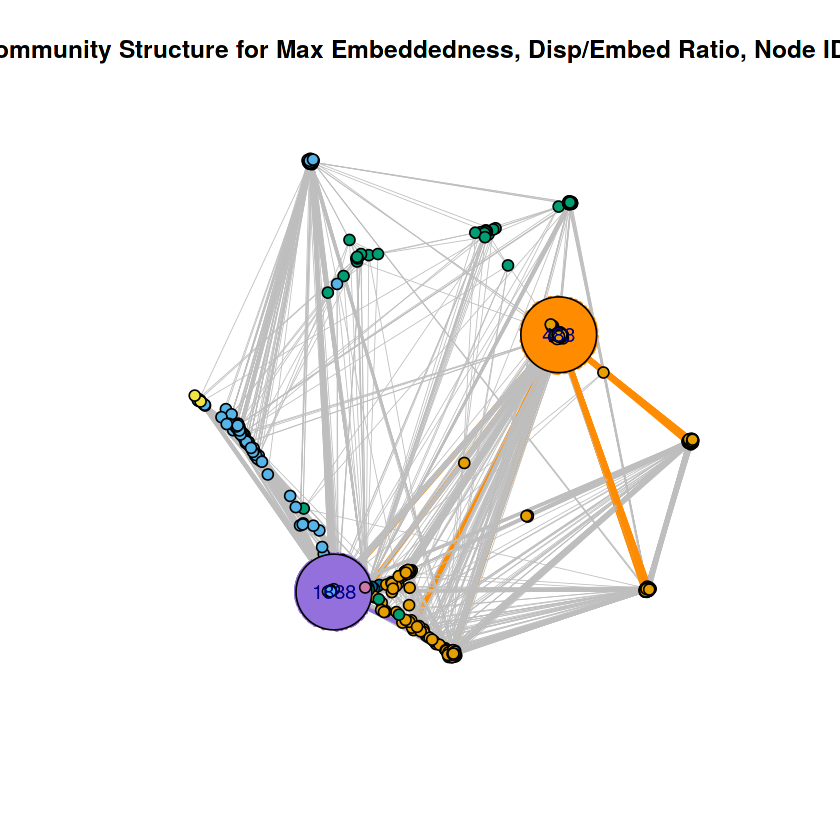

Maximum embeddedness node, personal net node 484: 107
Maximum disperson/embeddedness ratio node, personal net 484: 107


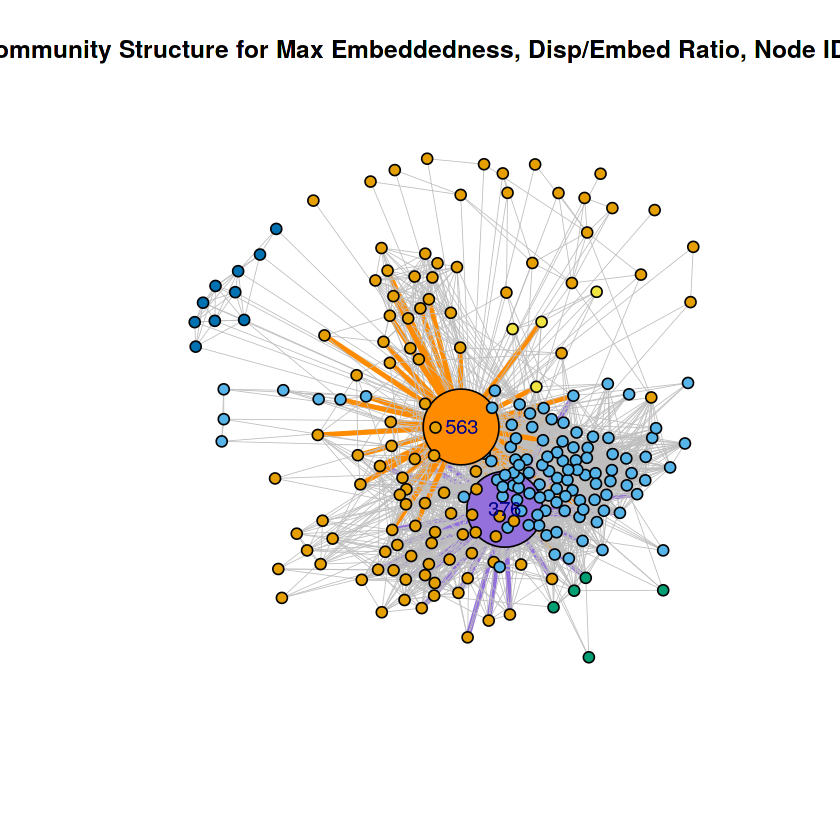

Maximum embeddedness node, personal net node 1087: 107
Maximum disperson/embeddedness ratio node, personal net 1087: 107


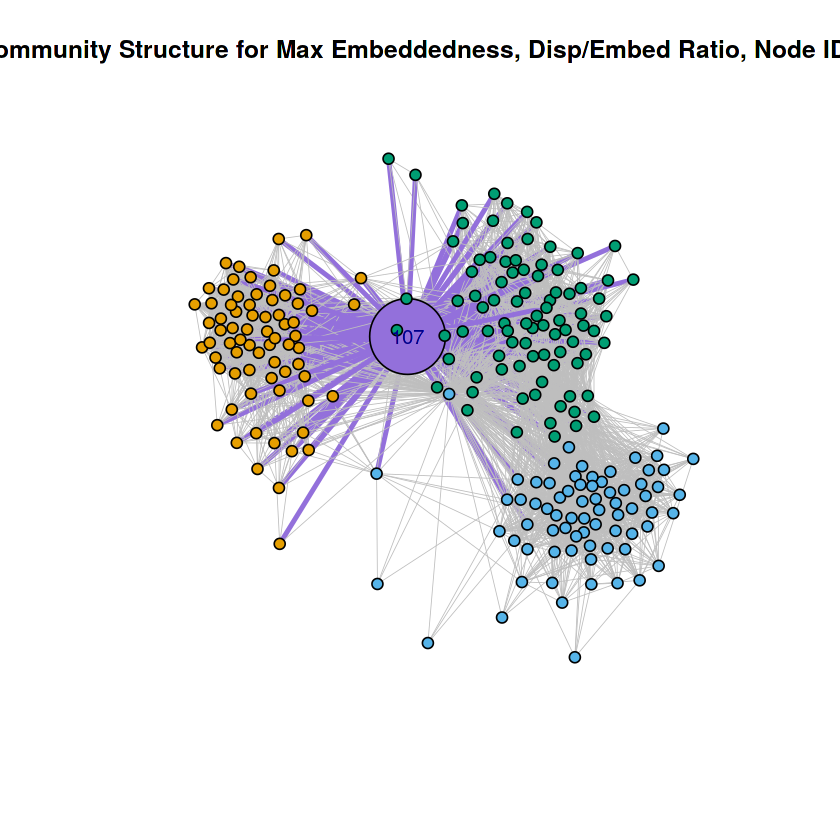

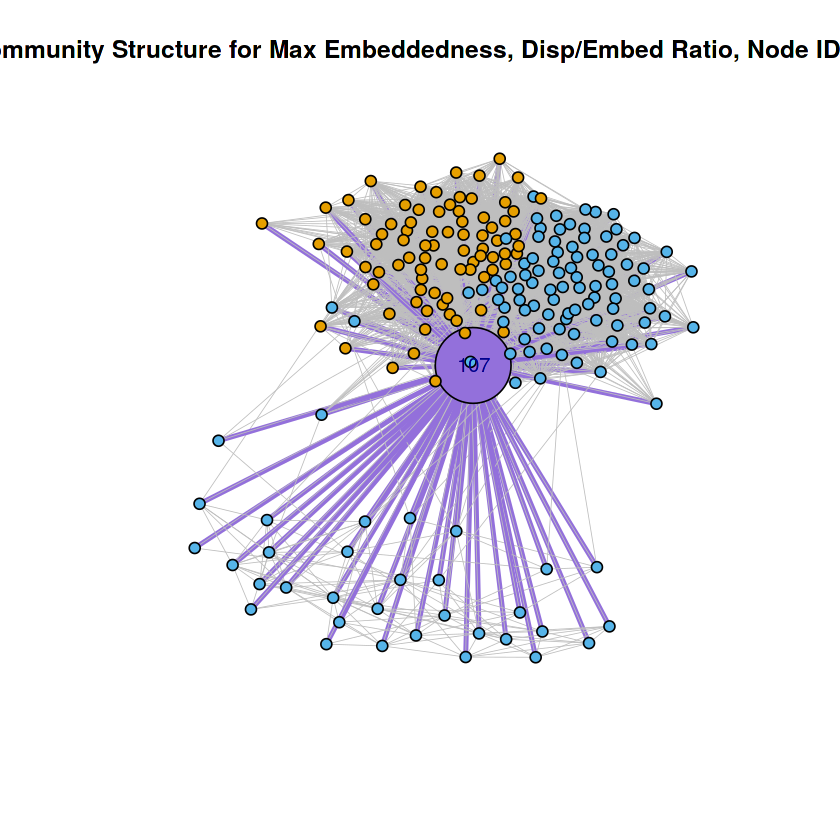

In [6]:
#mostly same structure as 13 but max embededness and dispersion/embeddedness



node_ids = c(0,107,348,483,1086)
graph_node_id = c(1,108,349,484,1087)
ego_net = make_ego_graph(g, 1, nodes=c('0','107','348','483','1086'))

for(i in 1:length(node_ids))
{
    personal_net = ego_net[[i]]
    subgraph_nodes = c(V(personal_net)$name)
    max_node =  NA
    max_dispersion = 0
    
    max_embed_node =  NA
    max_embed_value = 0
    #ratio = dispersion/embed
    max_ratio_node = NA
    max_ratio_value = 0
    
        for(n in subgraph_nodes)
        {
            calc_disp_embed = dispersion_embed(personal_net, toString(node_ids[i]), toString(n))
        
            if(calc_disp_embed[2] > max_embed_value && n != toString(node_ids[i]))
            {
                max_embed_value = calc_disp_embed[2]
                max_embed_node = n
            }
            if(calc_disp_embed[2] != 0 && (calc_disp_embed[1]/calc_disp_embed[2]) > max_ratio_value && n != toString(node_ids[i]))
            {
                max_ratio_value = calc_disp_embed[1]/calc_disp_embed[2]
                max_ratio_node = n
            }

        }
    personalized_com = fastgreedy.community(personal_net)

    
    node_color = rep(personalized_com$membership, length(V(personal_net)))
    node_size = rep(4, length(V(personal_net)))
    node_label = rep(NA, length(V(personal_net)))
    
    edge_color = rep("gray", length(E(personal_net)))
    edge_weight = rep(0.5, length(E(personal_net)))


    #max labeling/coloring
    
    node_color[which(V(personal_net)$name == max_ratio_node)] = "darkorange";
    node_color[which(V(personal_net)$name == max_embed_node)] = "mediumpurple";
    
    node_size[which(V(personal_net)$name == max_ratio_node |
                   V(personal_net)$name == max_embed_node)] = 30;
    node_label[which(V(personal_net)$name == max_ratio_node)] = max_ratio_node;
    node_label[which(V(personal_net)$name == max_embed_node)] = max_embed_node;
    
    edge_color[which(get.edgelist(personal_net, name = TRUE)[,1] == max_ratio_node | 
                     get.edgelist(personal_net, name = TRUE)[,2] == max_ratio_node)] = "darkorange";
    edge_color[which(get.edgelist(personal_net, name = TRUE)[,1] == max_embed_node | 
                     get.edgelist(personal_net, name = TRUE)[,2] == max_embed_node)] = "mediumpurple";

    edge_weight[which(get.edgelist(personal_net, name = TRUE)[,1] == max_ratio_node |  
                      get.edgelist(personal_net, name = TRUE)[,2] == max_ratio_node |
                      get.edgelist(personal_net, name = TRUE)[,1] == max_embed_node |
                      get.edgelist(personal_net, name = TRUE)[,2] == max_embed_node)] = 3;
   
    
    cat(paste('Maximum embeddedness node, personal net node ', graph_node_id[i],  ': ', max_embed_node, '\n', sep=''))
    cat(paste('Maximum disperson/embeddedness ratio node, personal net ', graph_node_id[i],  ': ', max_ratio_node, '\n', sep=''))
    plot(personal_net, vertex.size = node_size, vertex.label = node_label,
                edge.width = edge_weight, edge.color = edge_color, vertex.color = node_color, 
               main = paste("Community Structure for Max Embeddedness, Disp/Embed Ratio, Node ID:  ",graph_node_id[i], sep=''))
    
}

# Question 16

In [7]:
#edgelist 414 -> node id 515
specific_node_g = make_ego_graph(g, nodes=c('414'))

all_degrees = degree(specific_node_g[[1]])
Node_r = which(all_degrees == 24)
cat(paste('Length of the list N_r: ', length(Node_r), sep=''))

Length of the list N_r: 11